# Importing Libraries

In [ ]:
#from google.colab import files
#uploaded = files.upload()


In [1]:
import numpy as np, pandas as pd

#!pip install talos

import re
import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.tokenize import word_tokenize
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
import string
from string import ascii_lowercase

from tqdm import tqdm_notebook
import itertools
import io

import matplotlib.pyplot as plt
%matplotlib inline

from functools import reduce
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import BatchNormalization
from keras import initializers, regularizers, constraints, optimizers, layers
import talos

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Aaryan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Importing Data

In [2]:
# from google.colab import files
 
 
# uploaded = files.upload()

In [3]:
train=pd.read_csv('jigsaw-toxic-comment-train.csv')
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [4]:
# uploadedtest = files.upload()

In [5]:
test=pd.read_csv('test.csv')
# test.head(10)

# Data Exploration

Checking for missing values

In [6]:
train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [7]:
test.isnull().any()


id         False
content    False
lang       False
dtype: bool

In [8]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y = train[labels].values

#Data Pre-processing

## Text Normalization

* Removing Characters in between Text
* Removing Repeated Characters
* Converting data to lower-case
* Removing Numbers from the data
* Remove Punctuation
* Remove Whitespaces
* Removing spaces in between words
* Removing "\n"
* Remove Non-english characters

In [9]:
RE_PATTERNS = {
    ' american ':
        [
            'amerikan'
        ],

    ' adolf ':
        [
            'adolf'
        ],


    ' hitler ':
        [
            'hitler'
        ],

    ' fuck':
        [
            '(f)(u|[^a-z0-9 ])(c|[^a-z0-9 ])(k|[^a-z0-9 ])([^ ])*',
            '(f)([^a-z]*)(u)([^a-z]*)(c)([^a-z]*)(k)',
            ' f[!@#\$%\^\&\*]*u[!@#\$%\^&\*]*k', 'f u u c',
            '(f)(c|[^a-z ])(u|[^a-z ])(k)', r'f\*',
            'feck ', ' fux ', 'f\*\*', 'f**k','fu*k',
            'f\-ing', 'f\.u\.', 'f###', ' fu ', 'f@ck', 'f u c k', 'f uck', 'f ck'
        ],

    ' ass ':
        [
            '[^a-z]ass ', '[^a-z]azz ', 'arrse', ' arse ', '@\$\$',
            '[^a-z]anus', ' a\*s\*s', '[^a-z]ass[^a-z ]',
            'a[@#\$%\^&\*][@#\$%\^&\*]', '[^a-z]anal ', 'a s s','a55', '@$$'
        ],

    ' ass hole ':
        [
            ' a[s|z]*wipe', 'a[s|z]*[w]*h[o|0]+[l]*e', '@\$\$hole', 'a**hole'
        ],

    ' bitch ':
        [
            'b[w]*i[t]*ch', 'b!tch',
            'bi\+ch', 'b!\+ch', '(b)([^a-z]*)(i)([^a-z]*)(t)([^a-z]*)(c)([^a-z]*)(h)',
            'biatch', 'bi\*\*h', 'bytch', 'b i t c h', 'b!tch', 'bi+ch', 'l3itch'
        ],

    ' bastard ':
        [
            'ba[s|z]+t[e|a]+rd'
        ],

    ' trans gender':
        [
            'transgender'
        ],

    ' gay ':
        [
            'gay'
        ],

    ' cock ':
        [
            '[^a-z]cock', 'c0ck', '[^a-z]cok ', 'c0k', '[^a-z]cok[^aeiou]', ' cawk',
            '(c)([^a-z ])(o)([^a-z ]*)(c)([^a-z ]*)(k)', 'c o c k'
        ],

    ' dick ':
        [
            ' dick[^aeiou]', 'deek', 'd i c k', 'dik'
        ],

    ' suck ':
        [
            'sucker', '(s)([^a-z ]*)(u)([^a-z ]*)(c)([^a-z ]*)(k)', 'sucks', '5uck', 's u c k'
        ],

    ' cunt ':
        [
            'cunt', 'c u n t'
        ],

    ' bull shit ':
        [
            'bullsh\*t', 'bull\$hit'
        ],

    ' homo sex ual':
        [
            'homosexual'
        ],

    ' jerk ':
        [
            'jerk'
        ],

    ' idiot ':
        [
            'i[d]+io[t]+', '(i)([^a-z ]*)(d)([^a-z ]*)(i)([^a-z ]*)(o)([^a-z ]*)(t)', 'idiots'
                                                                                      'i d i o t'
        ],

    ' dumb ':
        [
            '(d)([^a-z ]*)(u)([^a-z ]*)(m)([^a-z ]*)(b)'
        ],

    ' shit ':
        [
            'shitty', '(s)([^a-z ]*)(h)([^a-z ]*)(i)([^a-z ]*)(t)', 'shite', '\$hit', 's h i t', '$h1t'
        ],

    ' shit hole ':
        [
            'shythole'
        ],

    ' retard ':
        [
            'returd', 'retad', 'retard', 'wiktard', 'wikitud'
        ],

    ' rape ':
        [
            ' raped'
        ],

    ' dumb ass':
        [
            'dumbass', 'dubass'
        ],

    ' ass head':
        [
            'butthead'
        ],

    ' sex ':
        [
            'sexy', 's3x', 'sexuality'
        ],


    ' nigger ':
        [
            'nigger', 'ni[g]+a', ' nigr ', 'negrito', 'niguh', 'n3gr', 'n i g g e r'
        ],

    ' shut the fuck up':
        [
            'stfu', 'st*u'
        ],

    ' pussy ':
        [
            'pussy[^c]', 'pusy', 'pussi[^l]', 'pusses', 'p*ssy'
        ],

    ' faggot ':
        [
            'faggot', ' fa[g]+[s]*[^a-z ]', 'fagot', 'f a g g o t', 'faggit',
            '(f)([^a-z ]*)(a)([^a-z ]*)([g]+)([^a-z ]*)(o)([^a-z ]*)(t)', 'fau[g]+ot', 'fae[g]+ot',
        ],

    ' mother fucker':
        [
            ' motha ', ' motha f', ' mother f', 'motherucker',
        ],

    ' whore ':
        [
            'wh\*\*\*', 'w h o r e'
        ],
    ' fucking ':
        [
            'f*$%-ing'
        ],
}


In [10]:
#Ascii Removal step
def asciiremoval(string):
    string = re.sub('[^a-zA-Z.\d\s]', '', string)
    return string

#Removing dates
def remove_dates(sentence):
    for i in range(0,277):
        df1[i] = df1[i].sub('(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\s\d{2}\s\d{4}', ' ', sentence)

#Removing Url
def remove_url(txt):
    txt_nourl=re.sub(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', '', txt)
    return txt_nourl

#Punctuation Removal
def removepunct(txt):
    txt_nopunct="".join((c for c in txt if c not in string.punctuation))
    return txt_nopunct

contractions = {
"ain't": "am not / are not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is",
"i'd": "I had / I would",
"i'd've": "I would have",
"i'll": "I shall / I will",
"i'll've": "I shall have / I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}










In [11]:
def clean_text(text,remove_repeat_text=True, remove_patterns_text=True, is_lower=True):

  if is_lower:
    text=text.lower()
    
  if remove_patterns_text:
    for target, patterns in RE_PATTERNS.items():
      for pat in patterns:
        text=str(text).replace(pat, target)
    

  if remove_repeat_text:
    text = re.sub(r'(.)\1{2,}', r'\1', text) 

  text = str(text).replace("\n", " ")
#Ascii Removal
  text = re.sub('[^a-zA-Z.\d\s]', '', text)
#URL removal
  text=re.sub(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', '', text)
#Remove all the special characters 
  text = re.sub(r'[^\w\s]',' ',text)
  text = re.sub('[0-9]',"",text)
  text = re.sub(" +", " ", text)
#Date Removal 
  text=re.sub('(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\s\d{2}\s\d{4}', ' ', text)
  text= re.sub('[^a-zA-Z.\d\s]', '', text)
  text = re.sub("([^\x00-\x7F])+"," ",text)
  return text 





Cleaning Training Data

In [12]:
train['comment_text']=train['comment_text'].apply(lambda x: clean_text(x))
train['comment_text'][1]

'daww he matches this background colour im seemingly stuck with thanks talk january utc'

Cleaning Test Data

In [13]:
test['content']=test['content'].apply(lambda x: clean_text(x))
test['content'][1048]

'franchement c est fastidieux de perdre du temps avec un contributeur qui visibelement joue au con avec moi depuis des mois en se livrant un pov pushing pourtant d avance vou l chec face des sources unanimes je ne peux plus supposer la bonne foi dans ces conditions merci d arrter de nous faire perdre du temps apollofox discuter '

In [14]:
train.to_csv('train_preprocessed_first.csv')
test.to_csv('test_preprocessed_first.csv')

In [15]:
#test=pd.read_csv('Data/train_preprocessed_first.csv')
#train=pd.read_csv('Data/test_preprocessed_first.csv')

## Lemmatization

In [16]:
comments_train=train['comment_text']
comments_test=test['content']

In [17]:
comments_train=list(comments_train)
comments_test=list(comments_test)

In [18]:
wordnet_lemmatizer = WordNetLemmatizer()

In [19]:
#Lemmatization
#Pos Tagging-Noun,verb,adjective,adverb
def lemma(text, lemmatization=True):
  output=""
  if lemmatization:
    text=text.split(" ")
    for word in text:
       word1 = wordnet_lemmatizer.lemmatize(word, pos = "n")
       word2 = wordnet_lemmatizer.lemmatize(word1, pos = "v")
       word3 = wordnet_lemmatizer.lemmatize(word2, pos = "a")
       word4 = wordnet_lemmatizer.lemmatize(word3, pos = "r")
       output=output + " " + word4
  else:
    output=text
  
  return str(output.strip()) 

Lemmatizing Training Data

In [20]:
lemmatized_train_data = [] 

for line in tqdm_notebook(comments_train, total=159571): 
    lemmatized_train_data.append(lemma(line))

  0%|          | 0/159571 [00:00<?, ?it/s]

In [21]:
lemmatized_train_data[152458]

'i agree with you about graemels intention he be a revert nazi and wikipedia ha a way of protect against this report him to the wprr threerevertrule notice board post by report the revert nazi graemel ha show himselfherself to be a revert nazi this be unacceptable on a site that be make by it user and not it admins if you feel you have be unjustly revert more than time over a hour period please report himher to the threerevertnoticeboard wprr it be time to take back what be ours'

Lemmatizing Test Data

In [22]:
lemmatized_test_data = [] 

for line in tqdm_notebook(comments_test, total=len(comments_test)): 
    lemmatized_test_data.append(lemma(line))

  0%|          | 0/63812 [00:00<?, ?it/s]

## Stopwords Removal

In [23]:
stopword_list=STOP_WORDS

Adding Single and Dual to STOP_WORDS

In [24]:
def iter_all_strings():
    for size in itertools.count(1):
        for s in itertools.product(ascii_lowercase, repeat=size):
            yield "".join(s)

dual_alpha_list=[]
for s in iter_all_strings():
    dual_alpha_list.append(s)
    if s == 'zz':
        break

In [25]:
dual_alpha_list.remove('i')
dual_alpha_list.remove('a')
dual_alpha_list.remove('am')
dual_alpha_list.remove('an')
dual_alpha_list.remove('as')
dual_alpha_list.remove('at')
dual_alpha_list.remove('be')
dual_alpha_list.remove('by')
dual_alpha_list.remove('do')
dual_alpha_list.remove('go')
dual_alpha_list.remove('he')
dual_alpha_list.remove('hi')
dual_alpha_list.remove('if')
dual_alpha_list.remove('is')
dual_alpha_list.remove('in')
dual_alpha_list.remove('me')
dual_alpha_list.remove('my')
dual_alpha_list.remove('no')
dual_alpha_list.remove('of')
dual_alpha_list.remove('on')
dual_alpha_list.remove('or')
dual_alpha_list.remove('ok')
dual_alpha_list.remove('so')
dual_alpha_list.remove('to')
dual_alpha_list.remove('up')
dual_alpha_list.remove('us')
dual_alpha_list.remove('we')

In [26]:
for letter in dual_alpha_list:
    stopword_list.add(letter)
print("Done!!")

Done!!


Checking for other words that we may need in STOP_WORDS

In [27]:
def search_stopwords(data, search_stop=True):
  output=""
  if search_stop:
    data=data.split(" ")
    for word in data:
      if not word in stopword_list:
        output=output+" "+word 
  else:
    output=data

  return str(output.strip())  

In [28]:
potential_stopwords = [] 

for line in tqdm_notebook(lemmatized_train_data, total=159571): 
    potential_stopwords.append(search_stopwords(line))

  0%|          | 0/159571 [00:00<?, ?it/s]

In [29]:
len(potential_stopwords)

223549

Combining all the sentences in the list into a single string

In [30]:
def string_combine(stopword):
  final_a=""
  for item in range(1,159571):
    final_a=final_a+" "+stopword[item]
  return final_a



In [31]:
total_string_potential=string_combine(potential_stopwords)

In [32]:
print(potential_stopwords)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Counting the number of words in each of the strings

In [33]:
def word_count(str):
    counts = dict()
    words = str.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    return counts

In [34]:
total_string_potential_dict=word_count(total_string_potential)


Converting Dictionaries to Dataframe

In [35]:
total_string_potential_df = pd.DataFrame(list(total_string_potential_dict.items()),columns = ['Word','Count'])

Getting Dataframe output in descending order

In [36]:
total_string_potential_df

,Word,Count
0,daww,1
1,match,1062
2,background,770
3,colour,335
4,seemingly,165
...,...,...
195350,nearendless,1
195351,imagebarackobamamother,2
195352,hanumakonda,1
195353,automaker,1


Retaining certain words and removing others from the above list

In [37]:
potential_stopwords=['editor', 'reference', 'thank', 'work','find', 'good', 'know', 'like', 'look', 'thing', 'want', 'time', 'list', 'section','wikipedia', 'doe', 'add','new', 'try', 'think', 'write','use', 'user', 'way', 'page']

Adding above retrived words into the stopwords list

In [38]:
for word in potential_stopwords:
    stopword_list.add(word)
print("Done!!")

Done!!


Removing Stopwords from Training Data

In [39]:
def remove_stopwords(text, remove_stop=True):
  output = ""
  if remove_stop:
    text=text.split(" ")
    for word in text:
      if word not in stopword_list:
        output=output + " " + word
  else :
    output=text

  return str(output.strip())      

In [40]:
processed_train_data = [] 

for line in tqdm_notebook(lemmatized_train_data, total=159571): 
    processed_train_data.append(remove_stopwords(line))

  0%|          | 0/159571 [00:00<?, ?it/s]

In [41]:
processed_train_data[152458]

'agree graemels intention revert nazi protect report wprr threerevertrule notice board post report revert nazi graemel himselfherself revert nazi unacceptable site admins feel unjustly revert hour period report himher threerevertnoticeboard wprr'

Removing Stopwords from Test Data

In [42]:
processed_test_data = [] 

for line in tqdm_notebook(lemmatized_test_data, total=153164): 
    processed_test_data.append(remove_stopwords(line))

  0%|          | 0/153164 [00:00<?, ?it/s]

# Model Building

In [43]:
max_features=100000      
maxpadlen = 200          
val_split = 0.2      
embedding_dim_fasttext = 300

Tokenization

In [44]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(processed_train_data))
list_tokenized_train = tokenizer.texts_to_sequences(processed_train_data)
list_tokenized_test = tokenizer.texts_to_sequences(processed_test_data)

In [45]:
word_index=tokenizer.word_index
print("Words in Vocabulary: ",len(word_index))

Words in Vocabulary:  263853


Padding

In [46]:
X_t=pad_sequences(list_tokenized_train, maxlen=maxpadlen, padding = 'post')
X_te=pad_sequences(list_tokenized_test, maxlen=maxpadlen, padding = 'post')

In [47]:
print('Tokenized sentences: \n', X_t[10])
print('One hot label: \n', y[10])

Tokenized sentences: 
 [  148   557 40917   240   197 40917   240    96    17   590    17   148
   359   557     1  1108   148   331  5462   148   151    17   378   270
   359   557    17     1  1343   148    17   378     2    32   148   557
   197   148   181    47    91   590   148   557    17     2   489   130
    10  1095   453  1093    17  2449   503    35   148    17   197   396
   359    11   274   197   227   161   118    21    19    29   181    78
    19     3   428  4765     5 40917   240   197 40917   240    96   271
   378   303    55   590    37    42    78   427  1501    37   271     7
   590  1319    78  1717   137    10   137  4994   137    93    42   519
  1233    16    78  1379   115   137  1689    78  1166     5   504    78
   478    36   271    55  3528   166  2233   466    36   308  1664    66
   181   237   161  2682    36    36  1674    78  5209  1674    78    36
    78    36   197   271    47    91   590     5    36   271   197    77
    10   842  3323    17    

In [48]:
indices = np.arange(X_t.shape[0])
np.random.shuffle(indices)

In [49]:
X_t = X_t[indices]
labels = y[indices]
print('Features are :','\n',X_t)
print('labels are:','\n',labels)

Features are : 
 [[  101  1430  7831 ...     0     0     0]
 [17352   199   307 ...     0     0     0]
 [  144   303   980 ...     0     0     0]
 ...
 [ 2734  1556  8661 ...     0     0     0]
 [ 3620  2124   403 ...     0     0     0]
 [  170  1109     0 ...     0     0     0]]
labels are: 
 [[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 ...
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


### Splitting data into Training and Validation Set

In [50]:
num_validation_samples = int(val_split*X_t.shape[0])
x_train = X_t[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = X_t[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]


In [51]:
print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  [17093  1562  9715   549  9055  1680]
validation:  [4291  400 2425  140 2249  437]


### Importing Fast Text

In [52]:
import requests, zipfile, io

zip_file_url = "https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip"

r = requests.get(zip_file_url)

z = zipfile.ZipFile(io.BytesIO(r.content))

z.extractall()


In [53]:
import codecs
embeddings_index_fasttext = {}

f = codecs.open('wiki-news-300d-1M.vec', encoding='utf-8')


for line in f:

    values = line.rstrip().rsplit(' ')

    word = values[0]

    coefs = np.asarray(values[1:], dtype='float32')

    embeddings_index_fasttext[word] = coefs

f.close()


In [54]:
embedding_matrix_fasttext = np.random.random((len(word_index) + 1, embedding_dim_fasttext))
for word, i in word_index.items():
    embedding_vector = embeddings_index_fasttext.get(word)
    if embedding_vector is not None:
        embedding_matrix_fasttext[i] = embedding_vector
        
print("Completed!")
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix_fasttext, axis=1) == 0))

Completed!
number of null word embeddings: 0


### Creating Model

#### Talos Grid Search  for LSTM-CNN Model

In [54]:
def toxic_classifier(x_train,y_train,x_val,y_val,params):

  inp=Input(shape=(maxpadlen, ),dtype='int32')

  embedding_layer = Embedding(len(word_index) + 1,
                           embedding_dim_fasttext,
                           weights = [embedding_matrix_fasttext],
                           input_length = maxpadlen,
                           trainable=False,
                           name = 'embeddings')
  embedded_sequences = embedding_layer(inp)

  x = LSTM(params['output_count_lstm'], return_sequences=True,name='lstm_layer')(embedded_sequences)

  x = Conv1D(filters=params['filters'], kernel_size=params['kernel_size'], padding='same', activation='relu', kernel_initializer='he_uniform')(x)

  x = MaxPooling1D(params['pool_size'])(x)
  
  x = GlobalMaxPool1D()(x)
  
  x = BatchNormalization()(x)
  
  x = Dense(params['output_1_count_dense'], activation=params['activation'], kernel_initializer='he_uniform')(x)
  
  x = Dropout(params['dropout'])(x)

  x = Dense(params['output_2_count_dense'], activation=params['activation'], kernel_initializer='he_uniform')(x)
  
  x = Dropout(params['dropout'])(x)
  
  preds = Dense(6, activation=params['last_activation'], kernel_initializer='glorot_uniform')(x)

  model = Model(inputs=inp, outputs=preds)

  model.compile(loss=params['loss'], optimizer=params['optimizer'], metrics=['accuracy'])

  model_info=model.fit(x_train,y_train, epochs=params['epochs'], batch_size=params['batch_size'],  validation_data=(x_val, y_val))

  return model_info, model

In [58]:
p={
    'output_count_lstm': [15,20],
    'output_1_count_dense': [10,15],
    'output_2_count_dense': [5,10],
    'filters' : [2],
    'kernel_size' : [3],
    'batch_size': [32],
    'pool_size': [1],
    'epochs':[1],
    'optimizer':['adam'],
    'activation':['relu'],
    'last_activation': ['sigmoid'],
    'dropout':[0.1,0.2],
    'loss': ['binary_crossentropy']   
}
# p={
#     'output_count_lstm': [3,4],
#     'output_1_count_dense': [2,3],
#     'output_2_count_dense': [1,2],
#     'batch_size': [32],
#     'pool_size': [1],
#     'epochs':[1],
#     'optimizer':['adam'],
#     'activation':['relu'],
#     'last_activation': ['sigmoid'],
#     'dropout':[0.1,0.2],
#     'loss': ['binary_crossentropy']   
# }

In [59]:
scan_results = talos.Scan(x=x_train,
               y=y_train,
               x_val=x_val,
               y_val=y_val,
               model=toxic_classifier,
               params=p,
               experiment_name='tcc',
               print_params=True)



  0%|                                                                                           | 0/16 [00:00<?, ?it/s]

{'output_count_lstm': 15, 'output_1_count_dense': 10, 'output_2_count_dense': 5, 'filters': 2, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 1, 'epochs': 1, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
5589/5589 [==============================] - 311s 55ms/step - loss: 0.0990 - accuracy: 0.9100 - val_loss: 0.0656 - val_accuracy: 0.9953


  0%|                                                                                           | 0/16 [07:48<?, ?it/s]


  6%|█████                                                                           | 1/16 [05:19<1:19:57, 319.82s/it]

{'output_count_lstm': 15, 'output_1_count_dense': 10, 'output_2_count_dense': 5, 'filters': 2, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 1, 'epochs': 1, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
5589/5589 [==============================] - 258s 46ms/step - loss: 0.1154 - accuracy: 0.8439 - val_loss: 0.0652 - val_accuracy: 0.9953




 12%|██████████                                                                      | 2/16 [09:43<1:06:51, 286.52s/it]

{'output_count_lstm': 15, 'output_1_count_dense': 10, 'output_2_count_dense': 10, 'filters': 2, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 1, 'epochs': 1, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
5589/5589 [==============================] - 265s 47ms/step - loss: 0.0943 - accuracy: 0.8673 - val_loss: 0.0634 - val_accuracy: 0.9953




 19%|███████████████                                                                 | 3/16 [14:10<1:00:10, 277.74s/it]

{'output_count_lstm': 15, 'output_1_count_dense': 10, 'output_2_count_dense': 10, 'filters': 2, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 1, 'epochs': 1, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
5589/5589 [==============================] - 267s 47ms/step - loss: 0.1141 - accuracy: 0.8678 - val_loss: 0.0630 - val_accuracy: 0.9953




 25%|████████████████████▌                                                             | 4/16 [18:38<54:48, 274.06s/it]

{'output_count_lstm': 15, 'output_1_count_dense': 15, 'output_2_count_dense': 5, 'filters': 2, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 1, 'epochs': 1, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
5589/5589 [==============================] - 271s 48ms/step - loss: 0.1663 - accuracy: 0.9453 - val_loss: 0.0607 - val_accuracy: 0.9953




 31%|█████████████████████████▋                                                        | 5/16 [23:11<50:10, 273.71s/it]

{'output_count_lstm': 15, 'output_1_count_dense': 15, 'output_2_count_dense': 5, 'filters': 2, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 1, 'epochs': 1, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
5589/5589 [==============================] - 270s 48ms/step - loss: 0.1195 - accuracy: 0.8664 - val_loss: 0.0658 - val_accuracy: 0.9953




 38%|██████████████████████████████▊                                                   | 6/16 [27:43<45:31, 273.16s/it]

{'output_count_lstm': 15, 'output_1_count_dense': 15, 'output_2_count_dense': 10, 'filters': 2, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 1, 'epochs': 1, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
5589/5589 [==============================] - 271s 48ms/step - loss: 0.1009 - accuracy: 0.9017 - val_loss: 0.0604 - val_accuracy: 0.9953




 44%|███████████████████████████████████▉                                              | 7/16 [32:17<40:58, 273.15s/it]

{'output_count_lstm': 15, 'output_1_count_dense': 15, 'output_2_count_dense': 10, 'filters': 2, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 1, 'epochs': 1, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
5589/5589 [==============================] - 268s 48ms/step - loss: 0.1152 - accuracy: 0.8628 - val_loss: 0.0629 - val_accuracy: 0.9953




 50%|█████████████████████████████████████████                                         | 8/16 [36:47<36:18, 272.27s/it]

{'output_count_lstm': 20, 'output_1_count_dense': 10, 'output_2_count_dense': 5, 'filters': 2, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 1, 'epochs': 1, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
5589/5589 [==============================] - 312s 55ms/step - loss: 0.1170 - accuracy: 0.8579 - val_loss: 0.0591 - val_accuracy: 0.9953




 56%|██████████████████████████████████████████████▏                                   | 9/16 [42:00<33:15, 285.11s/it]

{'output_count_lstm': 20, 'output_1_count_dense': 10, 'output_2_count_dense': 5, 'filters': 2, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 1, 'epochs': 1, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
5589/5589 [==============================] - 320s 57ms/step - loss: 0.1986 - accuracy: 0.7849 - val_loss: 0.0731 - val_accuracy: 0.9953




 62%|██████████████████████████████████████████████████▋                              | 10/16 [47:22<29:38, 296.49s/it]

{'output_count_lstm': 20, 'output_1_count_dense': 10, 'output_2_count_dense': 10, 'filters': 2, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 1, 'epochs': 1, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
5589/5589 [==============================] - 321s 57ms/step - loss: 0.0897 - accuracy: 0.8849 - val_loss: 0.0601 - val_accuracy: 0.9953




 69%|███████████████████████████████████████████████████████▋                         | 11/16 [52:45<25:22, 304.52s/it]

{'output_count_lstm': 20, 'output_1_count_dense': 10, 'output_2_count_dense': 10, 'filters': 2, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 1, 'epochs': 1, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
5589/5589 [==============================] - 418s 74ms/step - loss: 0.0953 - accuracy: 0.9065 - val_loss: 0.0608 - val_accuracy: 0.9953




 75%|████████████████████████████████████████████████████████████▊                    | 12/16 [59:45<22:38, 339.70s/it]

{'output_count_lstm': 20, 'output_1_count_dense': 15, 'output_2_count_dense': 5, 'filters': 2, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 1, 'epochs': 1, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
5589/5589 [==============================] - 434s 77ms/step - loss: 0.0972 - accuracy: 0.9625 - val_loss: 0.0690 - val_accuracy: 0.9953




 81%|████████████████████████████████████████████████████████████████▏              | 13/16 [1:07:02<18:27, 369.03s/it]

{'output_count_lstm': 20, 'output_1_count_dense': 15, 'output_2_count_dense': 5, 'filters': 2, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 1, 'epochs': 1, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
5589/5589 [==============================] - 435s 77ms/step - loss: 0.1131 - accuracy: 0.8350 - val_loss: 0.0642 - val_accuracy: 0.9953




 88%|█████████████████████████████████████████████████████████████████████▏         | 14/16 [1:14:21<13:00, 390.19s/it]

{'output_count_lstm': 20, 'output_1_count_dense': 15, 'output_2_count_dense': 10, 'filters': 2, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 1, 'epochs': 1, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
5589/5589 [==============================] - 404s 72ms/step - loss: 0.0953 - accuracy: 0.9088 - val_loss: 0.0848 - val_accuracy: 0.9953




 94%|██████████████████████████████████████████████████████████████████████████     | 15/16 [1:21:06<06:34, 394.79s/it]

{'output_count_lstm': 20, 'output_1_count_dense': 15, 'output_2_count_dense': 10, 'filters': 2, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 1, 'epochs': 1, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
5589/5589 [==============================] - 406s 72ms/step - loss: 0.0896 - accuracy: 0.9030 - val_loss: 0.0624 - val_accuracy: 0.9953




100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [1:27:53<00:00, 329.62s/it]


In [60]:
model_id = scan_results.data['val_accuracy'].astype('float').argmax()
model_id

0

In [61]:
scan_results.data[8:9]

,start,end,duration,round_epochs,loss,accuracy,val_loss,val_accuracy,output_count_lstm,output_1_count_dense,...,filters,kernel_size,batch_size,pool_size,epochs,optimizer,activation,last_activation,dropout,loss
8,04/27/23-000327,04/27/23-000840,312.624847,1,0.117041,0.857879,0.059105,0.995258,20,10,...,2,3,32,1,1,adam,relu,sigmoid,0.1,binary_crossentropy


In [62]:
analyze_object = talos.Analyze(scan_results)

In [63]:
analyze_object.best_params('val_accuracy', ['accuracy', 'loss', 'val_loss'])

array([[0.1, 5, 32, '04/26/23-233155', 1, '04/26/23-232640', 'adam', 10,
        2, 'relu', 'sigmoid', 1, 314.8048861026764, 1, 3, 15, 0],
       [0.2, 5, 32, '04/26/23-233621', 1, '04/26/23-233200', 'adam', 10,
        2, 'relu', 'sigmoid', 1, 261.26729130744934, 1, 3, 15, 1],
       [0.1, 10, 32, '04/26/23-234050', 1, '04/26/23-233623', 'adam', 10,
        2, 'relu', 'sigmoid', 1, 266.6623523235321, 1, 3, 15, 2],
       [0.2, 10, 32, '04/26/23-234518', 1, '04/26/23-234050', 'adam', 10,
        2, 'relu', 'sigmoid', 1, 267.8301923274994, 1, 3, 15, 3],
       [0.1, 5, 32, '04/26/23-234951', 1, '04/26/23-234519', 'adam', 15,
        2, 'relu', 'sigmoid', 1, 272.44671654701233, 1, 3, 15, 4],
       [0.2, 5, 32, '04/26/23-235423', 1, '04/26/23-234952', 'adam', 15,
        2, 'relu', 'sigmoid', 1, 271.4287168979645, 1, 3, 15, 5],
       [0.1, 10, 32, '04/26/23-235856', 1, '04/26/23-235424', 'adam', 15,
        2, 'relu', 'sigmoid', 1, 272.49248576164246, 1, 3, 15, 6],
       [0.2, 10, 32, 

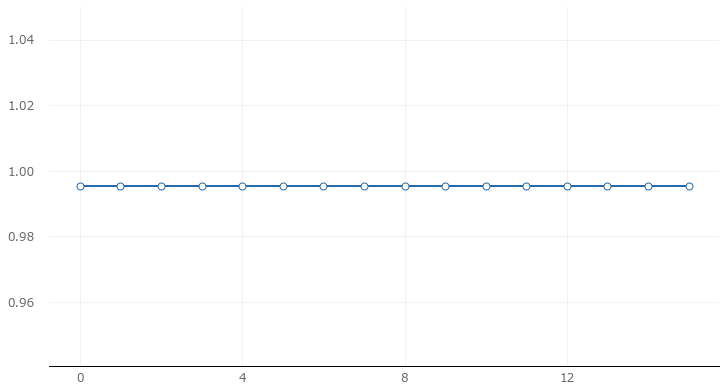

In [64]:
analyze_object.plot_line('val_accuracy')

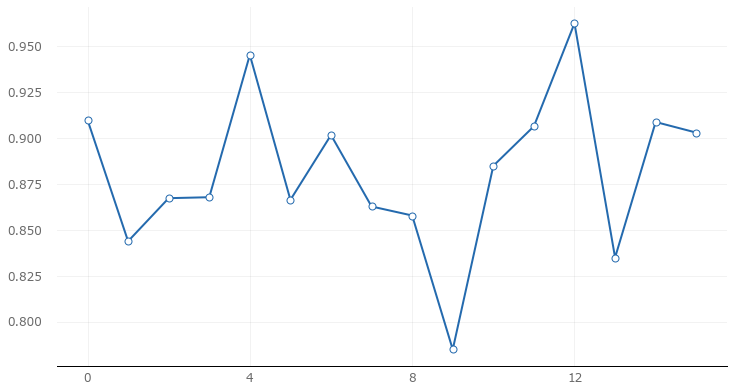

In [65]:
analyze_object.plot_line('accuracy')

#### Training Model with Best Parameters

LSTM-CNN

In [66]:
inp=Input(shape=(maxpadlen, ),dtype='int32')

In [67]:
embedding_layer = Embedding(len(word_index) + 1,
                           embedding_dim_fasttext,
                           weights = [embedding_matrix_fasttext],
                           input_length = maxpadlen,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(inp)

In [68]:
x = LSTM(50, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_uniform')(x)
x = MaxPooling1D(3)(x)
x = GlobalMaxPool1D()(x)
x = BatchNormalization()(x)
x = Dense(40, activation="relu", kernel_initializer='he_uniform')(x)
x = Dropout(0.2)(x)
x = Dense(30, activation="relu", kernel_initializer='he_uniform')(x)
x = Dropout(0.2)(x)
preds = Dense(6, activation="sigmoid", kernel_initializer='glorot_uniform')(x)

In [69]:
model_2 = Model(inputs=inp, outputs=preds)
model_2.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [70]:
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embeddings (Embedding)      (None, 200, 300)          79156200  
                                                                 
 lstm_layer (LSTM)           (None, 200, 50)           70200     
                                                                 
 conv1d (Conv1D)             (None, 200, 64)           9664      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 66, 64)           0         
 )                                                               
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                              

In [71]:
model_info_2=model_2.fit(x_train,y_train, epochs=2, batch_size=32,  validation_data=(x_val, y_val))

Epoch 1/2
5589/5589 [==============================] - 533s 95ms/step - loss: 0.0714 - accuracy: 0.9155 - val_loss: 0.0867 - val_accuracy: 0.9951
Epoch 2/2
5589/5589 [==============================] - 473s 85ms/step - loss: 0.0587 - accuracy: 0.9863 - val_loss: 0.0539 - val_accuracy: 0.9950


## Plotting Graphs

### LSTM-CNN

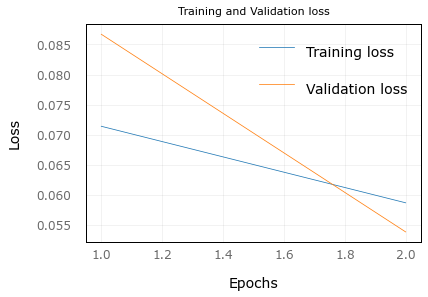

In [72]:
loss = model_info_2.history['loss']
val_loss = model_info_2.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

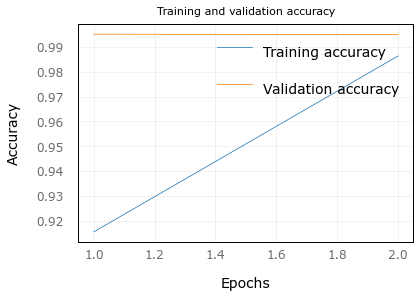

In [73]:
accuracy = model_info_2.history['accuracy']
val_accuracy = model_info_2.history['val_accuracy']

plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

# Saving the Model

In [75]:
model_2.save('Data/model2')

INFO:tensorflow:Assets written to: Data/model2\assets


INFO:tensorflow:Assets written to: Data/model2\assets


# Loading Saved Model

In [55]:
loaded_model_2 = keras.models.load_model('Data/model2')

# Generating the Output

### LSTM-CNN

In [56]:
test_values_2 = loaded_model_2.predict([X_te], batch_size=1, verbose=1)

63812/63812 [==============================] - 386s 6ms/step


In [57]:
sample_submission = pd.read_csv(r'D:\Aaryan project\Toxic-comment\Data\train_preprocessed_first.csv')
test_values_2=pd.DataFrame(test_values_2,columns=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
submission = pd.DataFrame(sample_submission["id"])
combined_submission=pd.concat([submission,test_values_2],axis=1)
combined_submission.to_csv(r'D:\Aaryan project\Toxic-comment\Data\combined_submission_model_2.csv', index=False)

# Testing the Created Model

In [58]:
def toxicity_level(string):
    new_string = [string]
    new_string = tokenizer.texts_to_sequences(new_string)
    new_string = pad_sequences(new_string, maxlen=maxpadlen, padding='post')
    
    prediction = loaded_model_2.predict(new_string) #(Change to model_1 or model_2 depending on the preference of model type|| Model 1: LSTM, Model 2:LSTM-CNN)
    
    print("Toxicity levels for '{}':".format(string))
    print('Toxic:         {:.0%}'.format(prediction[0][0]))
    print('Severe Toxic:  {:.0%}'.format(prediction[0][1]))
    print('Obscene:       {:.0%}'.format(prediction[0][2]))
    print('Threat:        {:.0%}'.format(prediction[0][3]))
    print('Insult:        {:.0%}'.format(prediction[0][4]))
    print('Identity Hate: {:.0%}'.format(prediction[0][5]))
    print()
    
    return

In [59]:
toxicity_level('go jump off a bridge jerk')

1/1 [==============================] - 0s 468ms/step
Toxicity levels for 'go jump off a bridge jerk':
Toxic:         74%
Severe Toxic:  3%
Obscene:       47%
Threat:        1%
Insult:        40%
Identity Hate: 1%



In [72]:
toxicity_level('')

1/1 [==============================] - 0s 23ms/step
Toxicity levels for 'you are good for nothing':
Toxic:         4%
Severe Toxic:  0%
Obscene:       1%
Threat:        0%
Insult:        1%
Identity Hate: 0%



In [78]:
toxicity_level('fucking idiot')

1/1 [==============================] - 0s 29ms/step
Toxicity levels for 'fucking idiot':
Toxic:         90%
Severe Toxic:  4%
Obscene:       72%
Threat:        0%
Insult:        51%
Identity Hate: 0%



In [65]:
toxicity_level('idiot fellow')

1/1 [==============================] - 0s 30ms/step
Toxicity levels for 'idiot fellow':
Toxic:         87%
Severe Toxic:  2%
Obscene:       61%
Threat:        0%
Insult:        46%
Identity Hate: 0%



In [66]:
toxicity_level('Dumb')

1/1 [==============================] - 0s 30ms/step
Toxicity levels for 'Dumb':
Toxic:         78%
Severe Toxic:  2%
Obscene:       47%
Threat:        0%
Insult:        40%
Identity Hate: 0%



In [68]:
toxicity_level('Bastard')

1/1 [==============================] - 0s 28ms/step
Toxicity levels for 'Bastard':
Toxic:         92%
Severe Toxic:  12%
Obscene:       78%
Threat:        1%
Insult:        59%
Identity Hate: 2%



In [85]:
toxicity_level('nigga')

1/1 [==============================] - 0s 31ms/step
Toxicity levels for 'nigga':
Toxic:         76%
Severe Toxic:  12%
Obscene:       45%
Threat:        12%
Insult:        52%
Identity Hate: 44%

